In [4]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [6]:
# load combined adata from 3 donors
adata = sc.read_h5ad('combined_adata.h5ad')
adata

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 33564 × 19958
    obs: 'revised_prediction', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

#### Integrating with scvi

In [7]:
# save raw count (that is without any normalozation or log applied)
adata.layers['raw_counts'] = adata.X.copy() # scvi use this layer

In [8]:
# Normalization 
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.normalized = adata # save normalized data (other modeule need normalized count)

In [9]:
adata.obs.head(2)

,revised_prediction,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AAACCCAAGCCTCTGG-1,singlet,donor1,4154,17016.0,0.0,0.0,2261.0,13.287494
AAACCCAAGCGACTTT-1,singlet,donor1,865,1536.0,0.0,0.0,103.0,6.705729


In [10]:
scvi.model.SCVI.setup_anndata(adata, layer = "raw_counts",
                             categorical_covariate_keys=["sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [11]:
model = scvi.model.SCVI(adata)
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 238/238: 100%|██████████| 238/238 [2:36:07<00:00, 27.87s/it, v_num=1, train_loss_step=5.49e+3, train_loss_epoch=5.4e+3]    

`Trainer.fit` stopped: `max_epochs=238` reached.


Epoch 238/238: 100%|██████████| 238/238 [2:36:07<00:00, 39.36s/it, v_num=1, train_loss_step=5.49e+3, train_loss_epoch=5.4e+3]


In [12]:
# scvi rep of the data
model.get_latent_representation().shape

(33564, 10)

In [13]:
adata.obsm['X_scVI'] = model.get_latent_representation()
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [14]:
sc.pp.neighbors(adata, use_rep='X_scVI')

In [15]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

C:\Users\19utk\AppData\Local\Temp\ipykernel_40796\4004962361.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


In [16]:
sc.tl.leiden(adata, resolution=0.25, key_added="leiden_0_25")

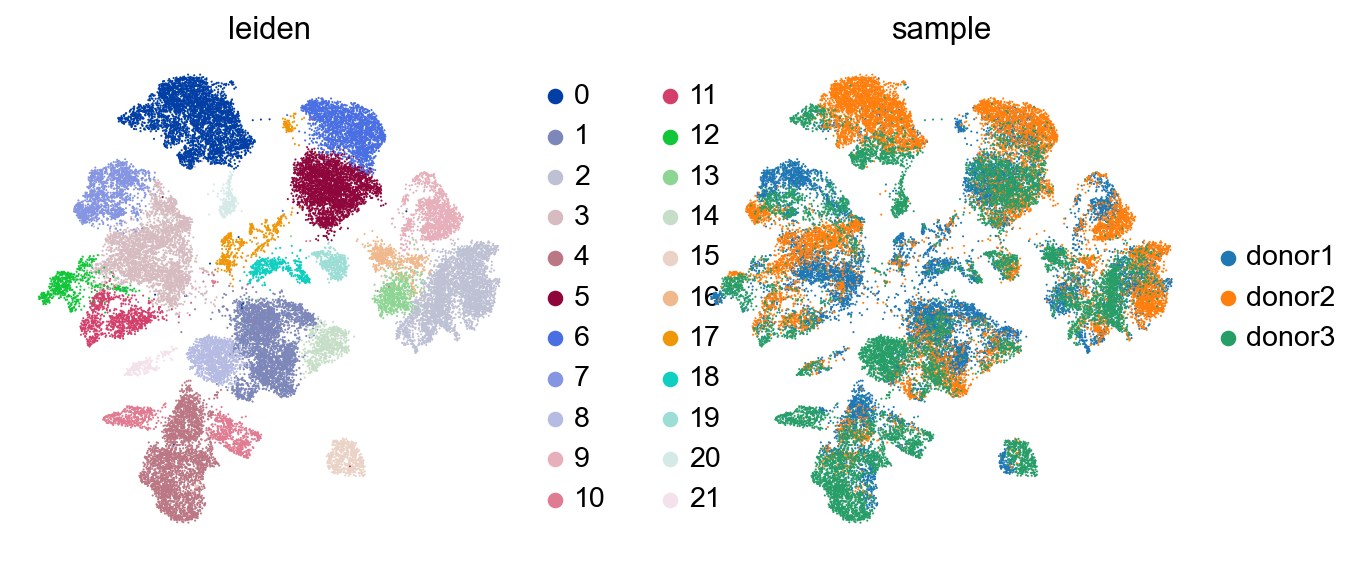

In [ ]:
sc.pl.umap(adata, color = ['leiden', 'sample']) # resolution = 0.5

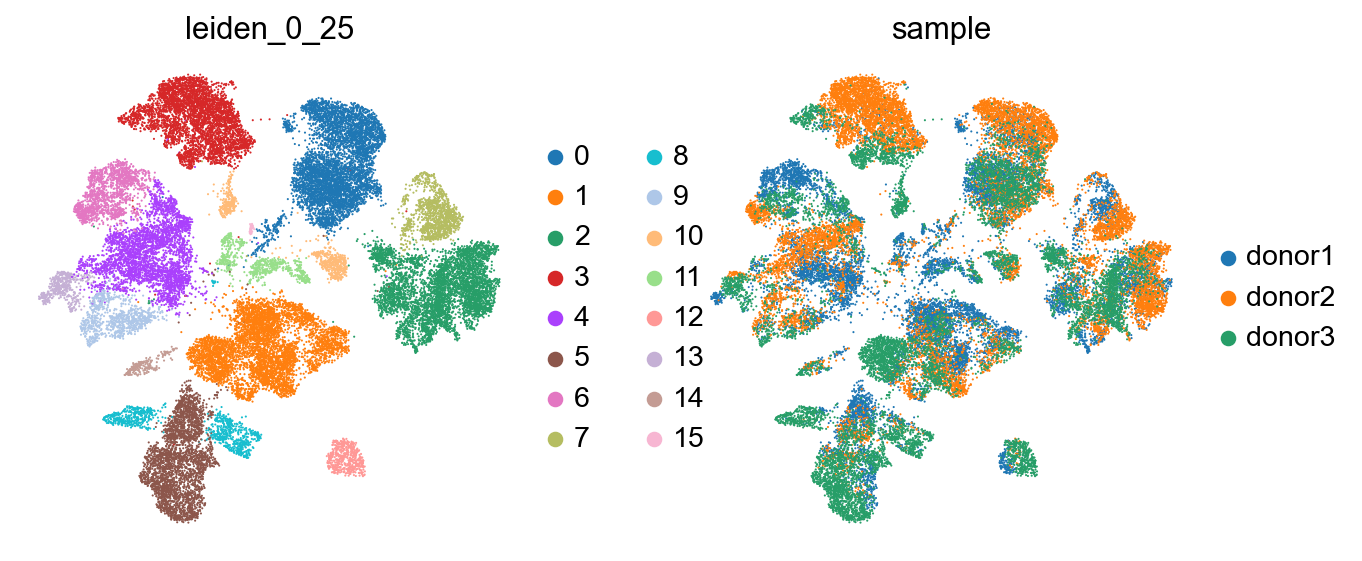

In [18]:
sc.pl.umap(adata, color = ['leiden_0_25', 'sample'])

In [19]:
adata.write_h5ad('integrated.h5ad')

#### Finding marker genes.

In [20]:
sc.tl.rank_genes_groups(adata, 'leiden_0_25')

In [22]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,CD69,112.215012,5.415492,0.0,0.0
1,0,BTG1,108.947853,2.663408,0.0,0.0
2,0,B2M,103.127235,1.715405,0.0,0.0
3,0,CXCR4,99.458115,4.238087,0.0,0.0
4,0,PTPRC,98.720688,3.471553,0.0,0.0


In [ ]:
markers_scvi = model.differential_expression(groupby = 'leiden_0_25')
markers_scvi

In [28]:
markers_scvi = markers_scvi[(markers_scvi['proba_m1'] > 0.95 ) & (markers_scvi["bayes_factor"] > 3)]
markers_scvi.head()

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison,group1,group2
CD8A,0.9976,0.0024,6.029880,0.000184,0.000007,0.523959,0.005565,0.256012,0.003924,1.594891,0.012080,0 vs Rest,0,Rest
CD2,0.9974,0.0026,5.949637,0.000454,0.000027,1.119870,0.014233,0.519074,0.009275,3.476722,0.030741,0 vs Rest,0,Rest
TRBC1,0.9972,0.0028,5.875328,0.000329,0.000017,1.197255,0.010309,0.475683,0.006136,3.560060,0.026749,0 vs Rest,0,Rest
LCK,0.9970,0.0030,5.806135,0.000187,0.000011,0.561566,0.007527,0.388176,0.006421,1.704514,0.017960,0 vs Rest,0,Rest
CD3G,0.9964,0.0036,5.623212,0.000497,0.000017,0.933102,0.007812,0.413488,0.004851,2.660509,0.014828,0 vs Rest,0,Rest


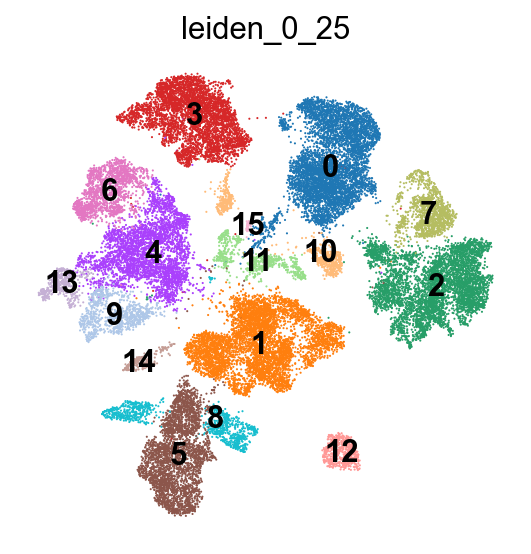

In [30]:
sc.pl.umap(adata, color = 'leiden_0_25', legend_loc='on data')

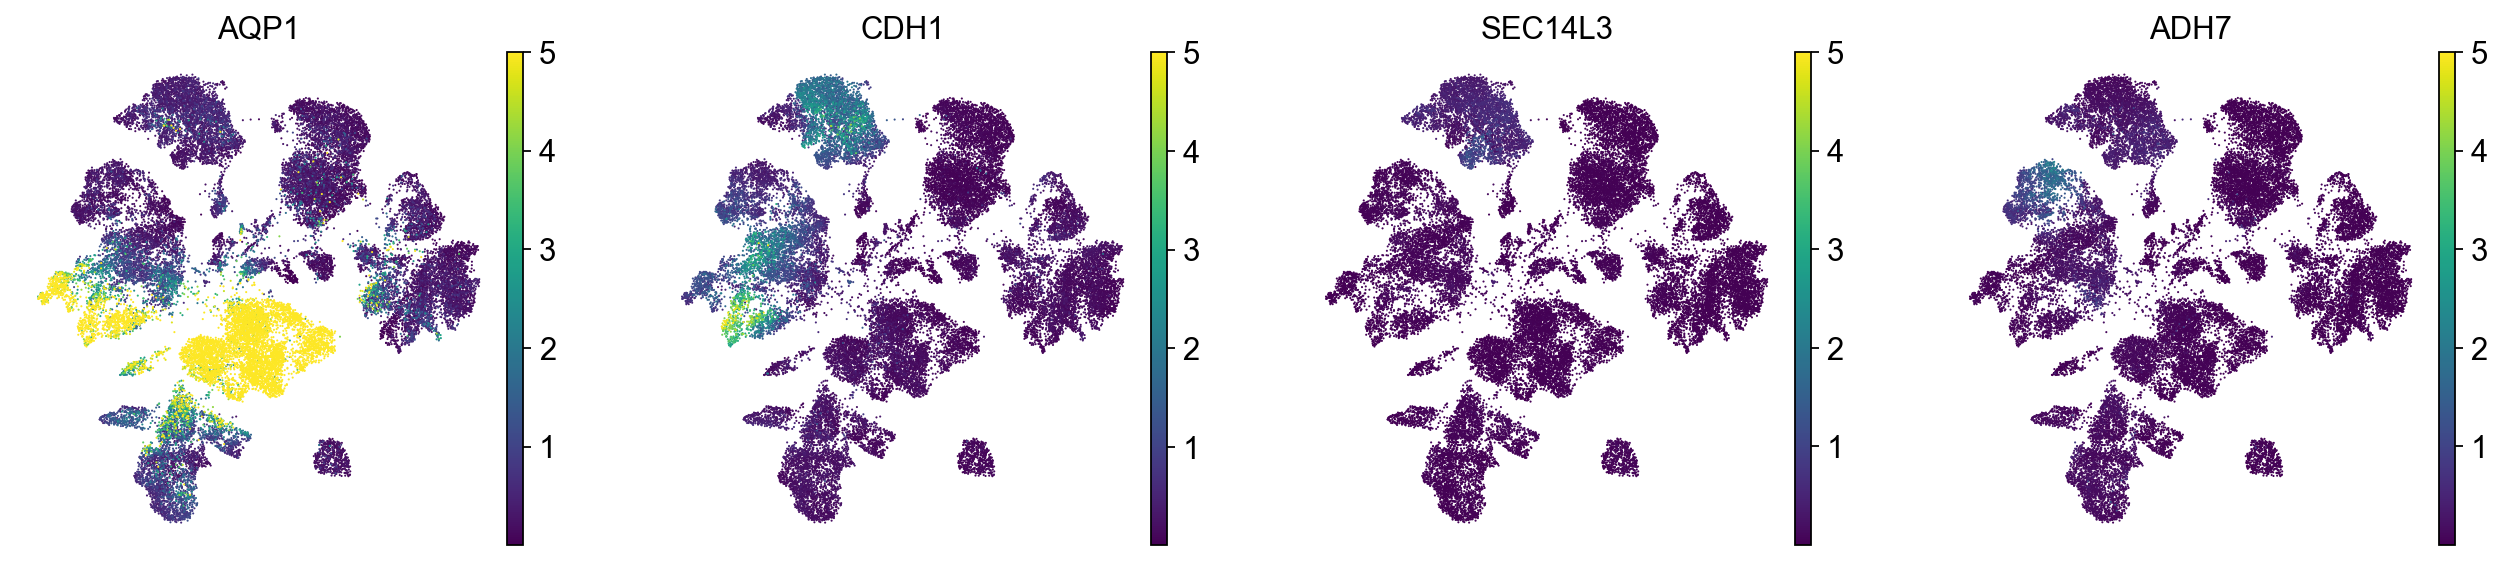

In [ ]:
# look up known marker genes for the cell types we expect and mark cluster accordingly
# these are marker genes for Airway epithelial cells
# source:  https://panglaodb.se/markers.html?cell_type=%27Airway%20epithelial%20cells%27
# PanglaoDB - Datasets - Cell Type Markers - choose cell type


sc.pl.umap(adata, color = ['AQP1', 'CDH1', 'SEC14L3', 'ADH7'], layer = 'scvi_normalized', vmax = 5)

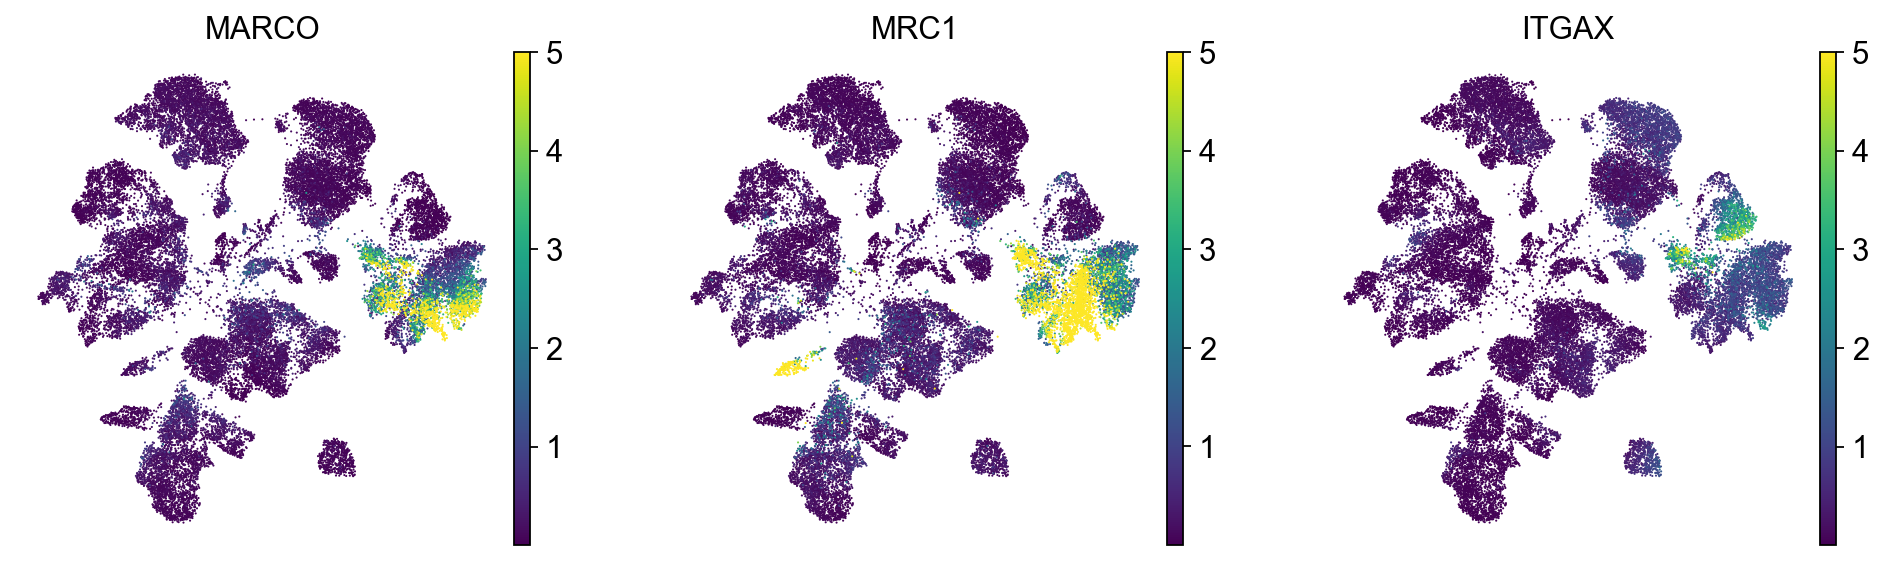

In [45]:
sc.pl.umap(adata, color = ['MARCO', 'MRC1', 'ITGAX'], layer = 'scvi_normalized', vmax = 5)

In [ ]:
celltype = {
"0: "",
"1: "Airway_epithelial",
"2: "Alveolar macrophages",
"3: " ",
"4: " ",
"5: " ",
"6: " ",
"7: " ",
"8: " ",
"9: " ",
"10: " ",
"11: " ",
"12: " ",
"13: " ",
"14: " ",
"15: " ",
}  
# fill up

'  celltype = {\n"0: " ",\n"1: " ",\n"2: " ",\n"3: " ",\n"4: " ",\n"5: " ",\n"6: " Epithelial",\n"7: " ",\n"8: " ",\n"9: " ",\n"10: " ",\n"11: " ",\n"12: " ",\n"13: " ",\n"14: " ",\n"15: " ",\n}  '

In [ ]:
# adata.obs['cell type'] = adata.obs.leiden.map(cell_type)
# sc.pl.umap(adata, color = ['cell type'])

In [46]:
adata.uns['scvi_markers'] = markers_scvi  # using scvi
adata.uns['markers'] = markers # using scanpy function

In [47]:
adata.write_h5ad('integrated.h5ad')

In [48]:
model.save('model.model')